<a href="https://colab.research.google.com/github/eman-kom/tensorflow-fundamentals/blob/main/04_transfer_learning_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Jun  4 06:31:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-06-04 06:31:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.69.128, 173.194.194.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.69.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.2’

10_food_classes_10_ 100%[===================>] 160.74M   265MB/s    in 0.6s    

2022-06-04 06:31:29 (265 MB/s) - ‘10_food_classes_10_percent.zip.2’ saved [168546183/168546183]



In [ ]:
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(len(dirnames), "directories\t", len(filenames), "images\t", dirpath)

2 directories	 0 images	 10_food_classes_10_percent
10 directories	 0 images	 10_food_classes_10_percent/train
0 directories	 75 images	 10_food_classes_10_percent/train/chicken_curry
0 directories	 75 images	 10_food_classes_10_percent/train/steak
0 directories	 75 images	 10_food_classes_10_percent/train/sushi
0 directories	 75 images	 10_food_classes_10_percent/train/fried_rice
0 directories	 75 images	 10_food_classes_10_percent/train/ice_cream
0 directories	 75 images	 10_food_classes_10_percent/train/hamburger
0 directories	 75 images	 10_food_classes_10_percent/train/chicken_wings
0 directories	 75 images	 10_food_classes_10_percent/train/ramen
0 directories	 75 images	 10_food_classes_10_percent/train/pizza
0 directories	 75 images	 10_food_classes_10_percent/train/grilled_salmon
10 directories	 0 images	 10_food_classes_10_percent/test
0 directories	 250 images	 10_food_classes_10_percent/test/chicken_curry
0 directories	 250 images	 10_food_classes_10_percent/test/steak
0 dir

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_data_10_percent = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [ ]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir)
  return tensorboard_callback

In [ ]:
res_net = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficient_net = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
def create_model(model_url, num_classes=10):
  feature_extractor_layer = hub.KerasLayer(
      model_url, 
      trainable=False,
      name="feature_extraction_layer",
      input_shape=IMAGE_SHAPE+(3,)
      )
  
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [ ]:
resnet_model = create_model(res_net)

In [ ]:
resnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [ ]:
history_1 = resnet_model.fit(
    train_data_10_percent, 
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=len(test_data_10_percent),
    callbacks=[create_tensorboard_callback("tensorflow_hub", "resnet50v2")]
    )

Epoch 1/5
24/24 [==============================] - 26s 1s/step - loss: 0.3385 - accuracy: 0.9347 - val_loss: 0.6464 - val_accuracy: 0.7880
Epoch 2/5
24/24 [==============================] - 24s 1s/step - loss: 0.2822 - accuracy: 0.9507 - val_loss: 0.6469 - val_accuracy: 0.7884
Epoch 3/5
24/24 [==============================] - 16s 678ms/step - loss: 0.2375 - accuracy: 0.9587 - val_loss: 0.6399 - val_accuracy: 0.7916
Epoch 4/5
24/24 [==============================] - 16s 670ms/step - loss: 0.2030 - accuracy: 0.9733 - val_loss: 0.6247 - val_accuracy: 0.7904
Epoch 5/5
24/24 [==============================] - 25s 1s/step - loss: 0.1774 - accuracy: 0.9813 - val_loss: 0.6288 - val_accuracy: 0.7912


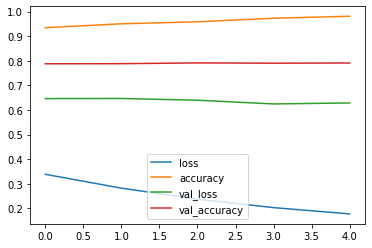

In [ ]:
import pandas as pd
pd.DataFrame(history_1.history).plot()

In [ ]:
efficientnet_model = create_model(efficient_net)

efficientnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

history_2 = efficientnet_model.fit(
    train_data_10_percent, 
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=len(test_data_10_percent),
    callbacks=[create_tensorboard_callback("tensorflow_hub", "efficientnet")]
    )

Epoch 1/5
24/24 [==============================] - 26s 744ms/step - loss: 1.7996 - accuracy: 0.4613 - val_loss: 1.2751 - val_accuracy: 0.7224
Epoch 2/5
24/24 [==============================] - 15s 648ms/step - loss: 1.0271 - accuracy: 0.7853 - val_loss: 0.8601 - val_accuracy: 0.8100
Epoch 3/5
24/24 [==============================] - 15s 644ms/step - loss: 0.7380 - accuracy: 0.8347 - val_loss: 0.6930 - val_accuracy: 0.8372
Epoch 4/5
24/24 [==============================] - 15s 646ms/step - loss: 0.5925 - accuracy: 0.8653 - val_loss: 0.6093 - val_accuracy: 0.8476
Epoch 5/5
24/24 [==============================] - 15s 648ms/step - loss: 0.5000 - accuracy: 0.8893 - val_loss: 0.5595 - val_accuracy: 0.8536


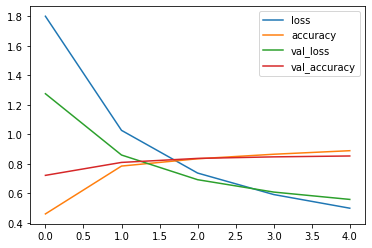

In [ ]:
pd.DataFrame(history_2.history).plot()